Data: https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set

Important information about the data's columns from the UCI Repository:
"0) The binary result of quality assessment. 0 = bad quality 1 = sufficient quality.

1) The binary result of pre-screening, where 1 indicates severe retinal abnormality and 0 its lack.

2-7) The results of MA detection. Each feature value stand for the
number of MAs found at the confidence levels alpha = 0.5, . . . , 1, respectively.

8-15) contain the same information as 2-7) for exudates. However,
as exudates are represented by a set of points rather than the number of
pixels constructing the lesions, these features are normalized by dividing the
number of lesions with the diameter of the ROI to compensate different image
sizes.

16) The euclidean distance of the center of
the macula and the center of the optic disc to provide important information
regarding the patientâ€™s condition. This feature
is also normalized with the diameter of the ROI.

17) The diameter of the optic disc.

18) The binary result of the AM/FM-based classification.

19) Class label. 1 = contains signs of DR (Accumulative label for the Messidor classes 1, 2, 3), 0 = no signs of DR."

In [59]:
#@title Import all relevant modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from google.colab import files
import io

In [60]:
#@title Get the file
uploaded = files.upload()

Saving messidor_features.csv to messidor_features (1).csv


In [65]:
#@title Turn the file into a pandas dataframe

data = pd.read_csv(io.StringIO(uploaded['messidor_features.csv'].decode('utf-8')), sep=',')

In [66]:
#@title Take a look at the data
print(data.head())

   0  1   2   3   4   5   6   7          8          9         10        11  \
0  1  1  22  22  22  19  18  14  49.895756  17.775994   5.270920  0.771761   
1  1  1  24  24  22  18  16  13  57.709936  23.799994   3.325423  0.234185   
2  1  1  62  60  59  54  47  33  55.831441  27.993933  12.687485  4.852282   
3  1  1  55  53  53  50  43  31  40.467228  18.445954   9.118901  3.079428   
4  1  1  44  44  44  41  39  27  18.026254   8.570709   0.410381  0.000000   

         12        13        14        15        16        17  18  19  
0  0.018632  0.006864  0.003923  0.003923  0.486903  0.100025   1   0  
1  0.003903  0.003903  0.003903  0.003903  0.520908  0.144414   0   0  
2  1.393889  0.373252  0.041817  0.007744  0.530904  0.128548   0   1  
3  0.840261  0.272434  0.007653  0.001531  0.483284  0.114790   0   0  
4  0.000000  0.000000  0.000000  0.000000  0.475935  0.123572   0   1  


In [67]:
#@title Looks like we need to normalize the data using Z-scores

for i in range(0, 19):
  data[str(i)] = (data[str(i)]-data[str(i)].mean())/data[str(i)].std()

In [68]:
#@title Look at the new normalized data
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.059028,0.298083,-0.641208,-0.618513,-0.576212,-0.629755,-0.550877,-0.473539,-0.242812,-0.245896,-0.296837,-0.271391,-0.218229,-0.194325,-0.205035,-0.186088,-1.294200,-0.468452,1.404438,0
1,0.059028,0.298083,-0.563146,-0.535545,-0.576212,-0.677115,-0.653392,-0.539757,-0.109202,0.032958,-0.465022,-0.408415,-0.224159,-0.197126,-0.205086,-0.186200,-0.082132,2.005183,-0.711410,0
2,0.059028,0.298083,0.920017,0.957883,1.046211,1.027853,0.935600,0.784609,-0.141322,0.227098,0.344313,0.768703,0.335392,0.152264,-0.109996,-0.164737,0.274163,1.121029,-0.711410,1
3,0.059028,0.298083,0.646803,0.667494,0.783115,0.838412,0.730568,0.652173,-0.404024,-0.214883,0.035815,0.316816,0.112524,0.056894,-0.195680,-0.199454,-1.423195,0.354347,-0.711410,0
4,0.059028,0.298083,0.217466,0.294137,0.388472,0.412170,0.525537,0.387300,-0.787727,-0.672014,-0.717023,-0.468107,-0.225730,-0.200818,-0.214874,-0.208009,-1.685142,0.843735,-0.711410,1


In [69]:
#@title Split the data into testing and training sets
train_data, test_data = train_test_split(data, train_size=.8)

In [70]:
#@title Create a feature layer

feature_columns=[]

# For each numeric feature, add it to the feature columns list
for i in range(0, 19):
  feature = tf.feature_column.numeric_column(str(i))
  feature_columns.append(feature)

# Turn the feature columns list into a feature layer
feature_layer = layers.DenseFeatures(feature_columns)

In [71]:
#@title Create model building function
def build_model(learning_rate, feature_layer, my_metrics):

  # The model is sequential
  model = tf.keras.models.Sequential()

  # Add feature layer to model
  model.add(feature_layer)

  # Create output layer with sigmoid function
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)
  

  # Compile model
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)
  
  return model

In [72]:
#@title Create model training function
def train_model(model, dataset, epochs, label_name, batch_size=None, shuffle=True):

  # Get features
  features = {name:np.array(value) for name, value in dataset.items()}

  # Get label
  label = np.array(features.pop(label_name)) 

  # Store history and fit the model
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  epochs =history.epoch

  hist = pd.DataFrame(history.history)

  return epochs, hist

In [73]:
#@title Create plot loss curve

def plot_loss(epochs, hist, metrics_list):
  
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for i in metrics_list:
    z=hist[i]
    plt.plot(epochs[1:], z[1:], label=str(i))
  
  plt.legend()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/50


10/10 [==============================] - 2s 3ms/step - loss: 1.3950 - Precision: 0.5742 - Recall: 0.5574
Epoch 2/50
10/10 [==============================] - 0s 3ms/step - loss: 0.9286 - Precision: 0.5720 - Recall: 0.5971
Epoch 3/50
10/10 [==============================] - 0s 3ms/step - loss: 0.7835 - Precision: 0.6127 - Recall: 0.6242
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7662 - Precision: 0.6379 - Recall: 0.6472
Epoch 5/50
10/10 [==============================] - 0s 3ms/step - loss: 0.8164 - Precision: 0.6436 - Recall: 0.6221
Epoch 6/50
10/10 [==============================] - 0s 3ms/step - loss: 0.7426 - Precision: 0.6652 - Recall: 0.6305
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.9127 - Precision: 0.6261 - Recall: 0.6221
Epoch 8/50
10/10 [==============================] - 0s 3ms/step - loss: 0.7173 - Precision: 0.6667 - Recall: 0.6305
Epoch 9/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6904 - Pr

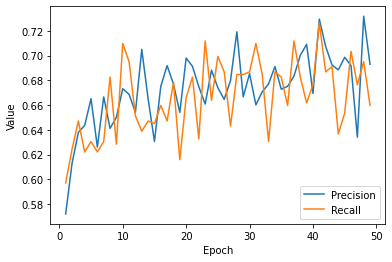

In [219]:
#@title Call the build model, train model, and plot loss function

# Hyperparameters
epochs=50
learning_rate=0.4
batch_size=100
label_name = "19"
classification_threshold=0.48

METRICS = [
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='Precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="Recall"),
]

# Build model
model = build_model(learning_rate, feature_layer, METRICS)

# Train model
epochs, hist = train_model(model, train_data, epochs, label_name, batch_size)

# Store list of metrics
metrics_to_plot = [ 'Precision', 'Recall']

# Plot metrics
plot_loss(epochs, hist, metrics_to_plot)

In [220]:
features = {name:np.array(value) for name, value in test_data.items()}
label = np.array(features.pop(label_name))

model.evaluate(x = features, y = label, batch_size=batch_size)

3/3 [==============================] - 1s 6ms/step - loss: 0.6516 - Precision: 0.7000 - Recall: 0.6894


[0.6516283750534058, 0.699999988079071, 0.689393937587738]

Sources:
Research Paper(Citation Request on UCI Repository): Balint Antal, Andras Hajdu: An ensemble-based system for automatic screening of diabetic retinopathy, Knowledge-Based Systems 60 (April 2014), 20-27.
https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set
https://developers.google.com/machine-learning/crash-course/classification/video-lecture